In [137]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import yfinance as yf
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [138]:
from fuzzywuzzy import process
import requests

In [139]:
company_request = 'msft'

In [178]:
def getCompany(text):
    r = requests.get('https://api.iextrading.com/1.0/ref-data/symbols')
    stockList = r.json()
    return process.extractOne(text, stockList)[0]

In [179]:
company = getCompany(company_request)

In [180]:
symbol = company['symbol']
company_name = company['name']
print(symbol)
print(company_name)

MSFT
MICROSOFT CORP


In [181]:
data = yf.download(symbol, parse_dates=True, infer_datetime_format=True)

[*********************100%***********************]  1 of 1 downloaded


In [182]:
data['Daily Return'] = data['Close'].dropna().pct_change()

In [183]:
# Set short and long windows
short_window = 50
long_window = 100

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

short_vol_window = 5
long_vol_window = 21

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']

# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

# Set the short window and long windows
rolling_short_window = 50
rolling_long_window = 100

# Generate the short and long moving averages (50 and 100 days, respectively)
data["SMA50"] = data["Close"].rolling(window=short_window).mean()
data["SMA100"] = data["Close"].rolling(window=long_window).mean()

# Initialize the new `Signal` column
data["SMA_Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
data["SMA_Signal"][short_window:] = np.where(
    data["SMA50"][short_window:] < data["SMA100"][short_window:], 1.0, 0.0
)

data

data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal
Date,,,,,,,,,,,,,,,,,,,,,
1986-03-13,0.09,0.1,0.09,0.1,0.06,1031788800,NaN,0.1,0.1,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
1986-03-14,0.10,0.1,0.10,0.1,0.06,308160000,0.0,0.1,0.1,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
1986-03-17,0.10,0.1,0.10,0.1,0.07,133171200,0.0,0.1,0.1,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
1986-03-18,0.10,0.1,0.10,0.1,0.06,67766400,0.0,0.1,0.1,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
1986-03-19,0.10,0.1,0.10,0.1,0.06,47894400,0.0,0.1,0.1,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0


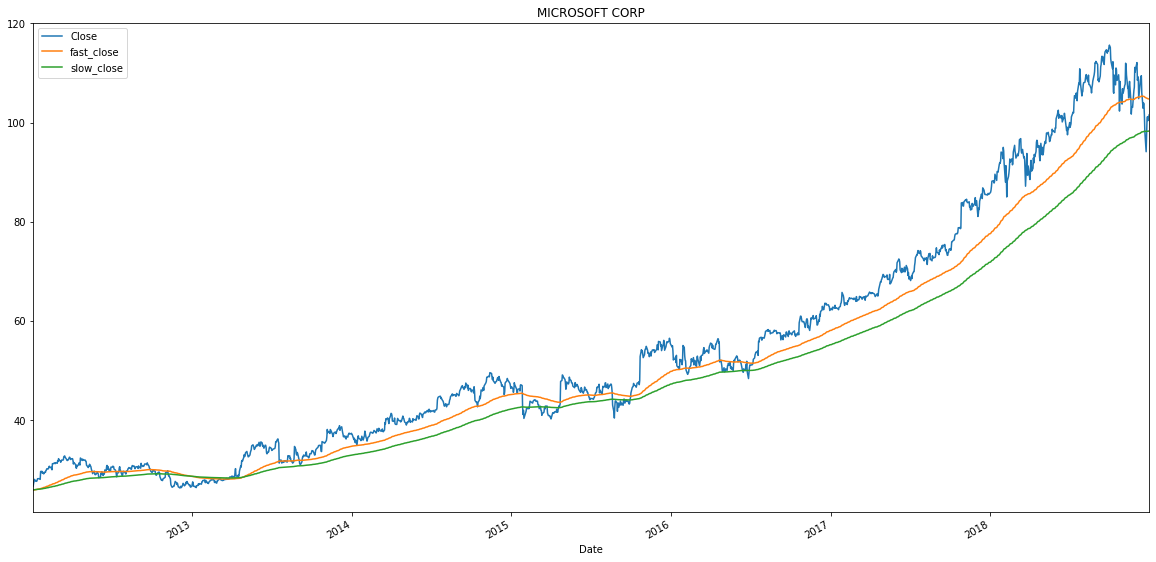

In [184]:
data.loc['2012-01-01':'2019-01-01'][['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10), title=company_name)

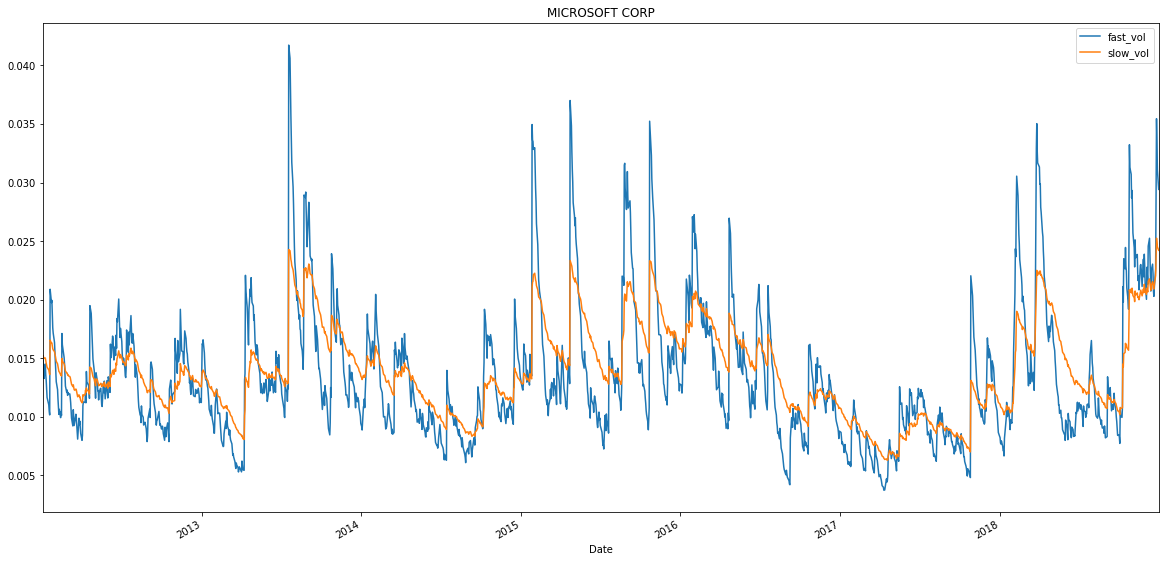

In [185]:
data.loc['2012-01-01':'2019-01-01'][['fast_vol', 'slow_vol']].plot(figsize=(20,10), title=company_name)

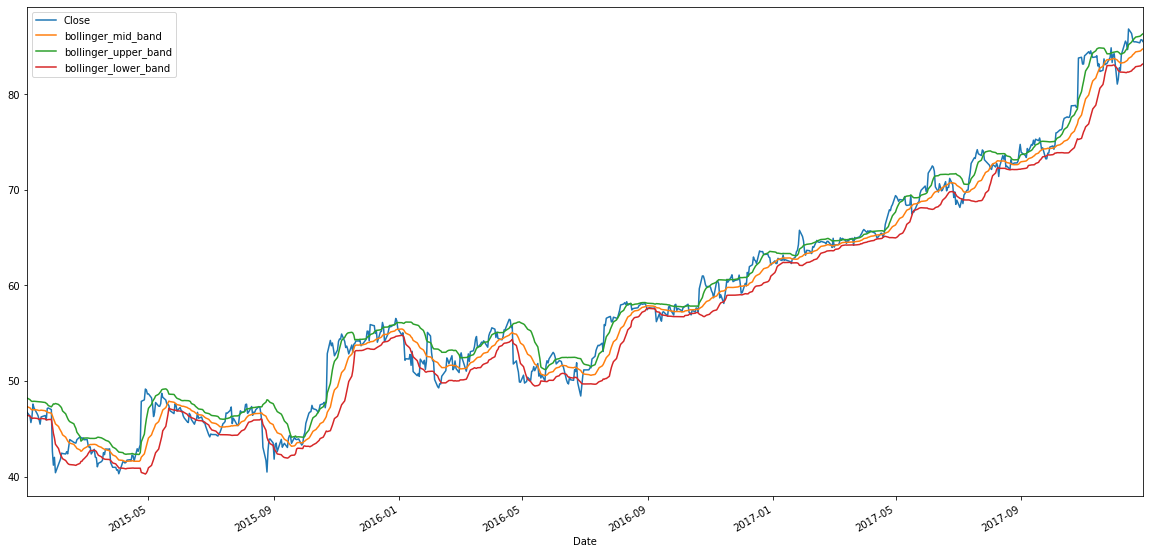

In [186]:
# Plot the Bollinger Bands for BTC/USD closing prices
data.loc['2015-01-01':'2018-01-01'][['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [187]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'SMA_Signal']

# Filter by x-variable list
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-12-06,1.0,1.0,-1.0,0.0
2019-12-09,1.0,1.0,0.0,0.0
2019-12-10,1.0,1.0,0.0,0.0
2019-12-11,1.0,1.0,-1.0,0.0
2019-12-12,1.0,1.0,-1.0,0.0


In [188]:
data[x_var_list] = data[x_var_list].shift(1)
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-12-06,1.0,1.0,0.0,0.0
2019-12-09,1.0,1.0,-1.0,0.0
2019-12-10,1.0,1.0,0.0,0.0
2019-12-11,1.0,1.0,0.0,0.0
2019-12-12,1.0,1.0,-1.0,0.0


In [189]:
#signal_dataand replace positive/negative infinity values
data.dropna(subset=x_var_list, inplace=True)
data.dropna(subset=['Daily Return'], inplace=True)
data = data.replace([np.inf, -np.inf], np.nan)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal
Date,,,,,,,,,,,,,,,,,,,,,
1986-03-14,0.1,0.1,0.10,0.1,0.06,308160000,0.0,0.1,0.1,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
1986-03-17,0.1,0.1,0.10,0.1,0.07,133171200,0.0,0.1,0.1,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
1986-03-18,0.1,0.1,0.10,0.1,0.06,67766400,0.0,0.1,0.1,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
1986-03-19,0.1,0.1,0.10,0.1,0.06,47894400,0.0,0.1,0.1,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
1986-03-20,0.1,0.1,0.09,0.1,0.06,58435200,0.0,0.1,0.1,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0


In [190]:
data['Positive Return'] = np.where(data['Daily Return'] > 0, 1.0, 0.0)
data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
1986-03-14,0.10,0.10,0.10,0.10,0.06,308160000,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
1986-03-17,0.10,0.10,0.10,0.10,0.07,133171200,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
1986-03-18,0.10,0.10,0.10,0.10,0.06,67766400,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
1986-03-19,0.10,0.10,0.10,0.10,0.06,47894400,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
1986-03-20,0.10,0.10,0.09,0.10,0.06,58435200,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-06,150.99,151.87,150.27,151.75,151.75,16403500,0.012139,137.393154,127.387593,1.0,...,1.846059,151.408559,147.716441,0.0,-1.0,0.0,143.8266,140.6782,0.0,1.0
2019-12-09,151.07,152.21,150.91,151.36,151.36,16687400,-0.002570,137.585440,127.553183,1.0,...,1.678749,151.511249,148.153751,0.0,0.0,-1.0,144.0992,140.8276,0.0,0.0
2019-12-10,151.29,151.89,150.76,151.13,151.13,16476100,-0.001520,137.771912,127.716040,1.0,...,1.452987,151.536487,148.630513,0.0,0.0,0.0,144.3412,140.9727,0.0,0.0


In [191]:
split = int(0.7 * len(signal_data))

In [192]:
# Construct training start and end dates
training_start = data.index.min().strftime(format= '%Y-%m-%d')
training_end = data.index[split - 1].strftime(format= '%Y-%m-%d')

# Construct testing start and end dates
testing_start =  data.index[split].strftime(format= '%Y-%m-%d')
testing_end = data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end} at 70% of data")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end} at latest data")

Training Start: 1986-03-14
Training End: 1991-01-25 at 70% of data
Testing Start: 1991-01-28
Testing End: 2019-12-12 at latest data


In [193]:
# Construct the x train and y train datasets
x_train = data[x_var_list][training_start:training_end]
y_train = data['Positive Return'][training_start:training_end]

x_train.tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
1991-01-21,1.0,1.0,-1.0,0.0
1991-01-22,1.0,-1.0,-1.0,0.0
1991-01-23,1.0,-1.0,-1.0,0.0
1991-01-24,1.0,-1.0,-1.0,0.0
1991-01-25,1.0,1.0,-1.0,0.0


In [194]:
# Construct the x test and y test datasets
x_test = data[x_var_list][testing_start:testing_end]
y_test = data['Positive Return'][testing_start:testing_end]

x_test.tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-12-06,1.0,1.0,0.0,0.0
2019-12-09,1.0,1.0,-1.0,0.0
2019-12-10,1.0,1.0,0.0,0.0
2019-12-11,1.0,1.0,0.0,0.0
2019-12-12,1.0,1.0,-1.0,0.0


# Start of Random Forest Testing 

In [195]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [198]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(x_train, y_train)

# Make a prediction of "y" values from the x test dataset
predictions = model.predict(x_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
result = y_test.to_frame()
data["Predicted Value"] = result
data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return,Predicted Value
Date,,,,,,,,,,,,,,,,,,,,,
1986-03-14,0.10,0.10,0.10,0.10,0.06,308160000,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1986-03-17,0.10,0.10,0.10,0.10,0.07,133171200,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1986-03-18,0.10,0.10,0.10,0.10,0.06,67766400,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1986-03-19,0.10,0.10,0.10,0.10,0.06,47894400,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1986-03-20,0.10,0.10,0.09,0.10,0.06,58435200,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-06,150.99,151.87,150.27,151.75,151.75,16403500,0.012139,137.393154,127.387593,1.0,...,151.408559,147.716441,0.0,-1.0,0.0,143.8266,140.6782,0.0,1.0,1.0
2019-12-09,151.07,152.21,150.91,151.36,151.36,16687400,-0.002570,137.585440,127.553183,1.0,...,151.511249,148.153751,0.0,0.0,-1.0,144.0992,140.8276,0.0,0.0,0.0
2019-12-10,151.29,151.89,150.76,151.13,151.13,16476100,-0.001520,137.771912,127.716040,1.0,...,151.536487,148.630513,0.0,0.0,0.0,144.3412,140.9727,0.0,0.0,0.0


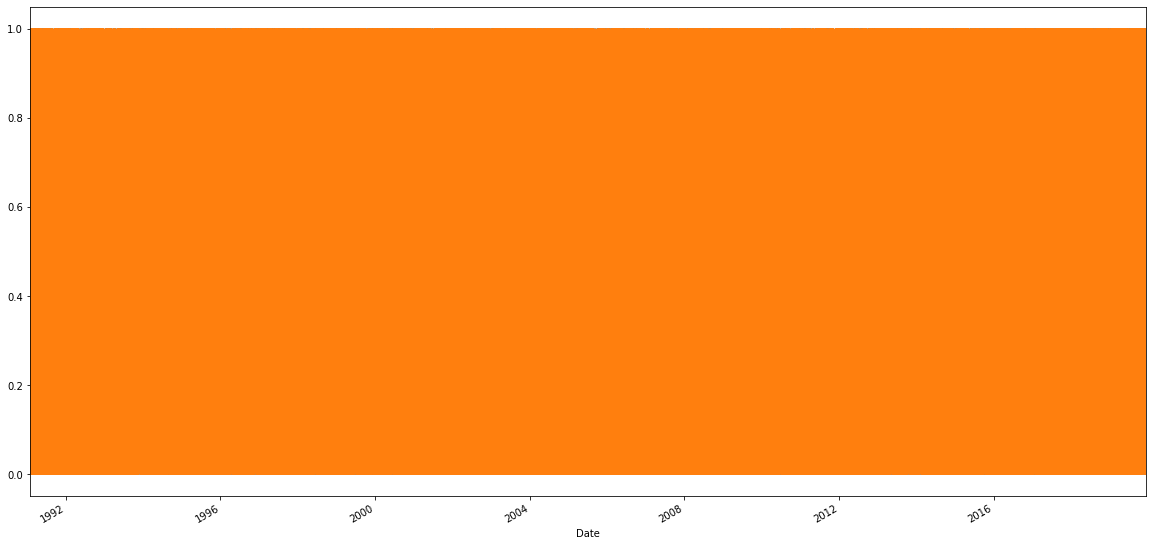

In [199]:
data['Positive Return'][testing_start:testing_end].plot(figsize=(20,10))
data['Predicted Value'][testing_start:testing_end].plot(figsize=(20,10))

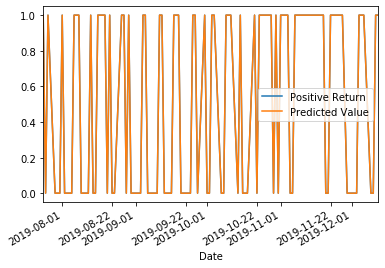

In [200]:
data[['Positive Return', 'Predicted Value']].tail(100).plot()

In [201]:
# Calculate the points in time at which a position should be taken, 1 or -1
data["Entry/Exit"] = data["Predicted Value"].diff()

In [203]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return,Predicted Value,Entry/Exit
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-06,150.99,151.87,150.27,151.75,151.75,16403500,0.012139,137.393154,127.387593,1.0,...,147.716441,0.0,-1.0,0.0,143.8266,140.6782,0.0,1.0,1.0,0.0
2019-12-09,151.07,152.21,150.91,151.36,151.36,16687400,-0.002570,137.585440,127.553183,1.0,...,148.153751,0.0,0.0,-1.0,144.0992,140.8276,0.0,0.0,0.0,-1.0
2019-12-10,151.29,151.89,150.76,151.13,151.13,16476100,-0.001520,137.771912,127.716040,1.0,...,148.630513,0.0,0.0,0.0,144.3412,140.9727,0.0,0.0,0.0,0.0
2019-12-11,151.54,151.87,150.33,151.70,151.70,18856600,0.003772,137.963664,127.881709,1.0,...,149.005675,0.0,-1.0,0.0,144.6338,141.1054,0.0,1.0,1.0,1.0
2019-12-12,151.65,153.44,151.02,153.24,153.24,23274620,0.010152,138.173977,128.056872,1.0,...,149.347845,0.0,-1.0,-1.0,145.0056,141.2449,0.0,1.0,1.0,0.0


In [214]:
type(data)

pandas.core.frame.DataFrame

AttributeError: 'Line2D' object has no property 'line_color'

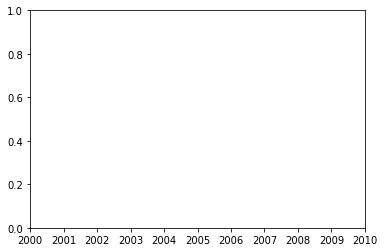

In [220]:
# Visualize exit position relative to close price
# exit = data[data['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
#     color='red',
#     marker='v',
#     size=200,
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# # Visualize entry position relative to close price
# entry = data[data['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
#     color='green',
#     marker='^',
#     size=200,
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# Visualize close price for the investment
security_close = data[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = data[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

In [ ]:
data

# DO NOT USE PAST THIS SPACE 

In [174]:
x_train=x_train.to_numpy()
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test= x_test.to_numpy()
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
y_train = y_train.to_numpy()
y_train = y_train.reshape((y_train.shape[0], 1))
y_test= y_test.to_numpy()
y_test = y_test.reshape((y_test.shape[0], 1))

In [175]:
x_train

array([[[ 23.83],
        [  0.  ],
        [  0.  ],
        [  0.  ],
        [  0.  ]],

       [[ 21.96],
        [ -1.  ],
        [  0.  ],
        [  0.  ],
        [  0.  ]],

       [[ 19.2 ],
        [ -1.  ],
        [ -1.  ],
        [  0.  ],
        [  0.  ]],

       ...,

       [[278.3 ],
        [  1.  ],
        [  1.  ],
        [ -1.  ],
        [  0.  ]],

       [[298.52],
        [  1.  ],
        [  1.  ],
        [ -1.  ],
        [  0.  ]],

       [[303.7 ],
        [  1.  ],
        [ -1.  ],
        [ -1.  ],
        [  0.  ]]])

In [ ]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

# THIS IS WHERE I WANT TO USE LSTM INSTEAD OF RANDOM FOREST IF ALL ELSE FAILS GO TO RANDOM FOREST

In [176]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [177]:
# Reshape the features for the model
print (f"X_train sample values:\n{x_train[:5]} \n")
print (f"X_test sample values:\n{x_test[:5]}")

X_train sample values:
[[[23.83]
  [ 0.  ]
  [ 0.  ]
  [ 0.  ]
  [ 0.  ]]

 [[21.96]
  [-1.  ]
  [ 0.  ]
  [ 0.  ]
  [ 0.  ]]

 [[19.2 ]
  [-1.  ]
  [-1.  ]
  [ 0.  ]
  [ 0.  ]]

 [[16.11]
  [-1.  ]
  [ 1.  ]
  [ 0.  ]
  [ 0.  ]]

 [[15.8 ]
  [-1.  ]
  [ 1.  ]
  [ 0.  ]
  [ 0.  ]]] 

X_test sample values:
[[[295.  ]
  [  1.  ]
  [ -1.  ]
  [ -1.  ]
  [  0.  ]]

 [[298.7 ]
  [  1.  ]
  [ -1.  ]
  [ -1.  ]
  [  0.  ]]

 [[302.54]
  [  1.  ]
  [ -1.  ]
  [ -1.  ]
  [  0.  ]]

 [[312.39]
  [  1.  ]
  [ -1.  ]
  [ -1.  ]
  [  0.  ]]

 [[308.71]
  [  1.  ]
  [ -1.  ]
  [ -1.  ]
  [  0.  ]]]


In [178]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(x_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [179]:
x_train.shape

(1785, 5, 1)

In [180]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [181]:
# Summarize the model
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_27 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_28 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_29 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)               

In [182]:
# Train the model
model.fit(x_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 1785 samples
Epoch 1/10
1785/1785 [==============================] - 40s 23ms/sample - loss: 0.2704
Epoch 2/10
1785/1785 [==============================] - 31s 17ms/sample - loss: 0.2607s - loss: -
Epoch 3/10
1785/1785 [==============================] - 29s 17ms/sample - loss: 0.2577
Epoch 4/10
1785/1785 [==============================] - 29s 17ms/sample - loss: 0.2539
Epoch 5/10
1785/1785 [==============================] - 29s 17ms/sample - loss: 0.2526
Epoch 6/10
1785/1785 [==============================] - 29s 16ms/sample - loss: 0.2510s - l
Epoch 7/10
1785/1785 [==============================] - 32s 18ms/sample - loss: 0.2510
Epoch 8/10
1785/1785 [==============================] - 31s 17ms/sample - loss: 0.2514
Epoch 9/10
1785/1785 [==============================] - 30s 17ms/sample - loss: 0.2514
Epoch 10/10
1717/1785 [===========================>..] - ETA: 1s - loss: 0.2508

KeyboardInterrupt: 

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
predicted = model.predict(x_test)

In [160]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

NameError: name 'scaler' is not defined